<a href="https://colab.research.google.com/github/tonywangs/cs131-final-project/blob/main/131_alternative.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [16]:
import cv2 as cv
import os
import numpy as np
import torch
import torch.nn as nn
import torchvision.transforms as transforms
import torchvision.models as models
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
! pip install torch torchvision matplotlib numpy
! pip install kaggle
from google.colab import drive
drive.mount('/content/drive')
! mkdir ~/.kaggle
! cp /root/kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json
! kaggle datasets download frlemarchand/nfl-player-numbers

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
mkdir: cannot create directory ‘/root/.kaggle’: File exists
cp: cannot stat '/root/kaggle.json': No such file or directory
chmod: cannot access '/root/.kaggle/kaggle.json': No such file or directory
Dataset URL: https://www.kaggle.com/datasets/frlemarchand/nfl-player-numbers
License(s): CC0-1.0
nfl-player-numbers.zip: Skipping, found more recently modified local copy (use --force to force download)


In [17]:
!zip -T nfl-player-numbers.zip

test of nfl-player-numbers.zip OK


In [18]:
! unzip nfl-player-numbers.zip -d nfl_data

Archive:  nfl-player-numbers.zip
replace nfl_data/train_player_numbers.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: n
replace nfl_data/train_player_numbers/57583_000082_Endzone_100_H27.png? [y]es, [n]o, [A]ll, [N]one, [r]ename: n
replace nfl_data/train_player_numbers/57583_000082_Endzone_100_H36.png? [y]es, [n]o, [A]ll, [N]one, [r]ename: n
replace nfl_data/train_player_numbers/57583_000082_Endzone_100_H50.png? [y]es, [n]o, [A]ll, [N]one, [r]ename: n
replace nfl_data/train_player_numbers/57583_000082_Endzone_100_H56.png? [y]es, [n]o, [A]ll, [N]one, [r]ename: a
error:  invalid response [a]
replace nfl_data/train_player_numbers/57583_000082_Endzone_100_H56.png? [y]es, [n]o, [A]ll, [N]one, [r]ename: n
replace nfl_data/train_player_numbers/57583_000082_Endzone_100_H90.png? [y]es, [n]o, [A]ll, [N]one, [r]ename: n
replace nfl_data/train_player_numbers/57583_000082_Endzone_100_H96.png? [y]es, [n]o, [A]ll, [N]one, [r]ename: n
replace nfl_data/train_player_numbers/57583_000082_Endzone_100_H97.png?

In [19]:
print(os.path.abspath("nfl-player-numbers.zip"))

/content/nfl-player-numbers.zip


In [20]:
import zipfile

zip_file_path = '/content/nfl-player-numbers.zip'
extract_to_folder = '/content/nfl_data'  # Choose your desired extraction path

with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(extract_to_folder)

print(f"Files extracted to: {extract_to_folder}")

Files extracted to: /content/nfl_data


In [21]:
# from google.colab.patches import cv2_imshow

# cap = cv.VideoCapture('/content/extracted_bundesliga_data/DFL Bundesliga Data Shootout/train/A1606b0e6_0/A1606b0e6_0 (35).mp4')

# images =

# while(cap.isOpened()):
#   ret, frame = cap.read()


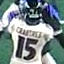

In [22]:
from google.colab.patches import cv2_imshow

image = cv.imread('/content/nfl_data/train_player_numbers/57583_000082_Endzone_100_V15.png')
cv2_imshow(image)

In [23]:
def gaussian_kernel(size, sigma):
  kernel = np.zeros((size, size))
  k = size // 2

  for i in range(size):
        for j in range(size):
            kernel[i,j] = np.exp(-((i-k)**2 + (j-k)**2)/(2*sigma**2)) / (2*np.pi*sigma**2)

  return kernel

def gradient(img):
  G = np.zeros(img.shape)
  theta = np.zeros(img.shape)

  k_x = [[-1,0,1],
        [-2,0,2],
        [-1,0,1]]

  k_y = [[1,2,1],
        [0,0,0],
        [-1,-2,-1]]

  x_partial = np.convolve(img, k_x)
  y_partial = np.convolve(img, k_y)

  G = np.sqrt(x_partial**2 + y_partial**2)
  theta = np.arctan2(y_partial, x_partial) / (2*np.pi) * 360
  theta = theta % 360

  return G, theta

def nms(G, theta):
  H, W = G.shape
  out = np.zeros((H, W))

  theta = np.floor((theta + 22.5) / 45) * 45
  theta = (theta % 360.0).astype(np.int32)

  for i in range(H):
      for j in range(W):
          if theta[i,j] == 0 or theta[i,j] == 180:
              before = G[i, max(j-1,0)]
              after = G[i, min(j+1,W-1)]

          elif theta[i,j] == 45 or theta[i,j] == (45+180):
              if i-1 < 0 or j-1 < 0:
                  before = 0
              else:
                  before = G[i-1, j-1]
              if i+1 > H-1 or j+1 > W-1:
                  after = 0
              else:
                  after = G[i+1, j+1]

          elif theta[i,j] == 90 or theta[i,j] == (90+180):
              before = G[max(i-1,0), j]
              after = G[min(i+1,H-1), j]

          else:
              if i-1 < 0 or j+1 > W-1:
                  before = 0
              else:
                  before = G[i-1, j+1]

              if i+1 > H-1 or j-1 < 0:
                  after = 0
              else:
                  after = G[i+1, j-1]

          out[i,j] = G[i,j] if max(G[i,j], before, after) == G[i,j] else 0

          return out

def double_thresholding(img, high, low):
    strong_edges = np.zeros(img.shape, dtype=bool)
    weak_edges = np.zeros(img.shape, dtype=bool)

    strong_edges = img > high
    weak_edges = (img > low) * (img <= high)

    return strong_edges, weak_edges

def get_neighbors(y, x, H, W):
    neighbors = []

    for i in (y-1, y, y+1):
        for j in (x-1, x, x+1):
            if i >= 0 and i < H and j >= 0 and j < W:
                if (i == y and j == x):
                    continue
                neighbors.append((i, j))

    return neighbors

def link_edges(strong_edges, weak_edges):
    H, W = strong_edges.shape
    indices = np.stack(np.nonzero(strong_edges)).T
    edges = np.zeros((H, W), dtype=bool)

    weak_edges = np.copy(weak_edges)
    edges = np.copy(strong_edges)

    for r, c in indices:
        Q = []
        Q.append((r, c))

        while Q:
            y, x = Q.pop(0)
            for i, j in get_neighbors(y, x, H, W):
                if weak_edges[i, j] == True:
                    weak_edges[i, j] = False
                    edges[i, j] = True
                    Q.append((i, j))

    return edges

In [49]:
# Image pre-processing and edge detection
! pip install scipy
import scipy

def canny(img, kernel_size=5, sigma=1.4, high=20, low=15):
  img = cv.cvtColor(img, cv.COLOR_BGR2GRAY)
  print(f"Image: {img.shape}")

  kernel = gaussian_kernel(kernel_size, sigma)
  print(f"Kernel: {kernel.shape}")

  smoothed = scipy.ndimage.convolve(img, kernel)
  G, theta = gradient(smoothed)
  non_max = nms(G, theta)
  strong, weak = double_thresholding(non_max, high, low)
  edge = link_edges(strong, weak)

  return edge

In [50]:
import matplotlib.pyplot as plt

canny_img = canny(image)

# Displaying the input and output image
plt.figure()
f, plots = plt.subplots(2, 1)
plots[0].imshow(image)
plots[1].imshow(canny_img)

Image: (64, 64)
Kernel: (5, 5)


ValueError: object too deep for desired array